<a href="https://colab.research.google.com/github/Yashvi2307/DrowsinessDetection/blob/master/drowsiness_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this Notebook i am training a CNN(Convolutional Neural network) based classsifier and saving the model to use it further with OpenCV.**


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from keras.models import Sequential
from keras.utils import np_utils
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPool2D, Dropout, BatchNormalization, Conv2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


<a id='1'></a>
# Load and Check Data

In [ ]:
size=150
data=[]
assign_dict = {"Eyes closed":0, "Eyes open":1}
def load_data(directory):
    for sub_directory in os.listdir(directory):
        if sub_directory=="Eyes closed":
            inner_directory=os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img=cv2.imread(os.path.join(inner_directory,i),0)
                img=cv2.resize(img,(size,size))
                data.append([img,assign_dict[sub_directory]])
                
        if sub_directory=="Eyes open":
            inner_directory=os.path.join(directory,sub_directory)
            for i in os.listdir(inner_directory):
                img=cv2.imread(os.path.join(inner_directory,i),0)
                img=cv2.resize(img,(size,size))
                data.append([img,assign_dict[sub_directory]])        
            
    random.shuffle(data)
    return np.array(data)
            
    

In [ ]:
train=load_data('/content/train')
val = load_data('/content/val')
test = load_data('/content/test')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
train

array([[array([[ 28,  31,  31, ...,  23,  23,  23],
       [ 28,  29,  29, ...,  23,  23,  23],
       [ 29,  29,  29, ...,  23,  23,  23],
       ...,
       [115, 110, 107, ...,  88,  84,  79],
       [113, 109, 108, ...,  87,  83,  77],
       [110, 107, 109, ...,  86,  85,  78]], dtype=uint8),
        0],
       [array([[ 52,  56,  57, ..., 108,  86,  86],
       [ 55,  55,  53, ...,  96,  87,  87],
       [ 56,  54,  52, ...,  90,  91,  95],
       ...,
       [147, 146, 147, ..., 118, 116, 122],
       [145, 144, 145, ..., 122, 116, 115],
       [144, 142, 140, ..., 123, 117, 114]], dtype=uint8),
        1],
       [array([[104,  66,  59, ...,  28,  28,  28],
       [ 84,  64,  62, ...,  30,  31,  32],
       [ 71,  66,  70, ...,  33,  30,  33],
       ...,
       [135, 135, 137, ..., 123, 114, 111],
       [136, 135, 136, ..., 118, 111, 104],
       [139, 138, 137, ..., 118, 112, 101]], dtype=uint8),
        0],
       ...,
       [array([[ 63,  59,  64, ...,  44,  92, 131],
   

In [ ]:
total_count=0
num_closed=0
num_open=0
closed=[]
open=[]
for i in train:
    if (i[1]==0):
        total_count=total_count+1
        num_closed=num_closed+1
        closed.append(i[0])
    else:
        total_count=total_count+1
        num_open=num_open+1
        open.append(i[0]) 
print('Total img: '+str(total_count))        
print('Eyes open : '+str(num_open))
print('Eyes closed: '+str(num_closed))

Total img: 1406
Eyes open : 701
Eyes closed: 705


<a id='2'></a>
# Some Images

<Figure size 1296x1296 with 0 Axes>

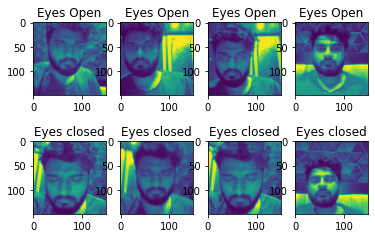

In [ ]:
rows=2
cols=4
fig=plt.figure(figsize=(18,18))
fig, ax = plt.subplots(2, 4)
for i in range(rows):
    for j in range(cols):
        if i<1:
            ax[i,j].imshow(open[j])
            ax[i,j].set_title('Eyes Open')
        else:
            ax[i,j].imshow(closed[j])
            ax[i,j].set_title('Eyes closed')
        

In [ ]:
x_train=[]
y_train=[]
for x,y in train:
    x_train.append(x)
    y_train.append(y)

In [ ]:
x_val=[]
y_val=[]
for x,y in val:
    x_val.append(x)
    y_val.append(y)

In [ ]:
x_test=[]
y_test=[]
for x,y in test:
    x_test.append(x)
    y_test.append(y)

In [ ]:
x_train=np.array(x_train)/255
x_val=np.array(x_val)/255
x_test=np.array(x_test)/255

In [ ]:
x_train=x_train.reshape(-1,size,size,1)
y_train=np.array(y_train)
x_val=x_val.reshape(-1,size,size,1)
y_val=np.array(y_val)
x_test=x_test.reshape(-1,size,size,1)
y_test=np.array(y_test)


<a id='3'></a>
# ImageGenerator and CNN Model

In [ ]:
image_gen=ImageDataGenerator(rotation_range=30,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            featurewise_center=False,  
                            samplewise_center=False, 
                            featurewise_std_normalization=False,  
                            samplewise_std_normalization=False, 
                            zca_whitening=False,  
                            zoom_range=0.2,
                            horizontal_flip=True
                            )


In [ ]:
model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "sgd" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience = 2, 
                              verbose=1,
                              factor=0.25, 
                              min_lr=0.000001)

<a id='4'></a>
# Model Traning

In [ ]:
history = model.fit(image_gen.flow(x_train,y_train, batch_size = 25),
                                 epochs = 10 ,
                                 validation_data = image_gen.flow(x_val, y_val),
                                 callbacks = [reduce_lr]
                   )

Epoch 1/10
57/57 [==============================] - 40s 118ms/step - loss: 1.1043 - accuracy: 0.6149 - val_loss: 1.1813 - val_accuracy: 0.4951
Epoch 2/10
57/57 [==============================] - 6s 98ms/step - loss: 0.4758 - accuracy: 0.7606 - val_loss: 1.5761 - val_accuracy: 0.4951
Epoch 3/10
57/57 [==============================] - 6s 99ms/step - loss: 0.4082 - accuracy: 0.7964 - val_loss: 1.4971 - val_accuracy: 0.4951

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
Epoch 4/10
57/57 [==============================] - 6s 98ms/step - loss: 0.3784 - accuracy: 0.8097 - val_loss: 1.6648 - val_accuracy: 0.4951
Epoch 5/10
57/57 [==============================] - 6s 98ms/step - loss: 0.3388 - accuracy: 0.8358 - val_loss: 1.8073 - val_accuracy: 0.4951

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 6/10
57/57 [==============================] - 6s 98ms/step - loss: 0.3056 - accuracy: 0.8728 - val_loss: 1.6847 - val_accurac

In [ ]:
model.save('model1.h5')

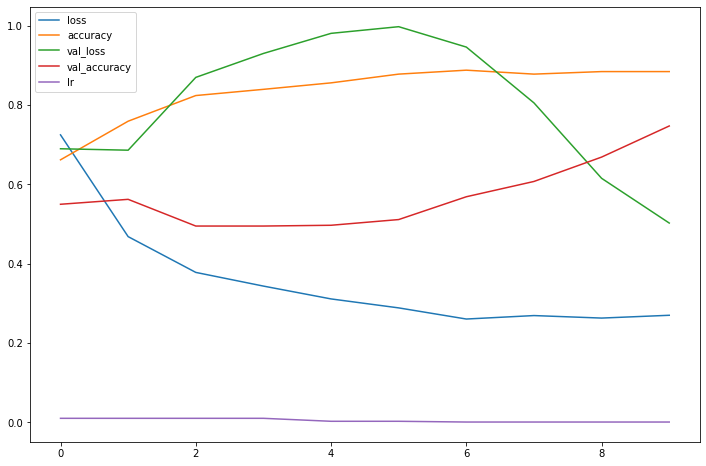

In [ ]:
pd.DataFrame(model.history.history).plot(figsize=(12,8))


<a id='5'></a>
# Result

In [ ]:
prediction=model.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(classification_report(prediction, y_test))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       804
           1       0.80      0.77      0.78       834

    accuracy                           0.78      1638
   macro avg       0.78      0.78      0.78      1638
weighted avg       0.78      0.78      0.78      1638



In [ ]:
confusion_matrix(prediction, y_test)

array([[814, 317],
       [ 17, 490]])